# Do FE with train and test together and then seperate them later


In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
import lightgbm as lgb
import os
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
#import pandas_profiling
import gc

In [2]:
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:50].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    #plt.savefig('lgbm_importances01.png')

In [3]:
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')

## FE

In [4]:
train_df.tail(10)

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
199990,train_199990,1,14.1475,1.8568,11.0066,3.6779,12.1944,-16.5936,5.3217,14.8508,...,-6.4708,4.7287,1.9034,7.2324,20.6047,1.7170,-4.0032,9.1627,13.8077,-1.9646
199991,train_199991,0,9.9909,2.5523,11.9653,6.3958,13.5497,-9.5293,6.0864,14.1789,...,12.0737,5.2139,0.8094,-0.6585,17.0548,0.5328,-5.3444,8.5414,13.2895,-6.7896
199992,train_199992,0,12.2825,2.6918,15.4684,6.4262,10.9863,9.9659,4.5030,9.9232,...,3.9514,10.9040,1.3472,5.6184,20.5498,-0.2854,7.6252,10.1758,17.4066,-11.5244
199993,train_199993,0,13.2152,-5.8006,9.7260,6.5910,12.4612,-7.1652,6.0666,12.9887,...,3.9357,8.8442,1.8096,-4.8314,22.0050,0.3916,6.7302,8.9709,14.5405,6.1149
199994,train_199994,0,12.3925,-5.8821,11.2323,3.9237,10.4509,10.7262,7.0503,18.6968,...,1.3911,6.8687,3.7788,6.3378,14.4656,-1.4843,-3.9299,9.1164,16.3170,-7.5048
199995,train_199995,0,11.4880,-0.4956,8.2622,3.5142,10.3404,11.6081,5.6709,15.1516,...,6.1415,13.2305,3.9901,0.9388,18.0249,-1.7939,2.1661,8.5326,16.6660,-17.8661
199996,train_199996,0,4.9149,-2.4484,16.7052,6.6345,8.3096,-10.5628,5.8802,21.5940,...,4.9611,4.6549,0.6998,1.8341,22.2717,1.7337,-2.1651,6.7419,15.9054,0.3388
199997,train_199997,0,11.2232,-5.0518,10.5127,5.6456,9.3410,-5.4086,4.5555,21.5571,...,4.0651,5.4414,3.1032,4.8793,23.5311,-1.5736,1.2832,8.7155,13.8329,4.1995
199998,train_199998,0,9.7148,-8.6098,13.6104,5.7930,12.5173,0.5339,6.0479,17.0152,...,2.6840,8.6587,2.7337,11.1178,20.4158,-0.0786,6.7980,10.0342,15.5289,-13.9001
199999,train_199999,0,10.8762,-5.7105,12.1183,8.0328,11.5577,0.3488,5.2839,15.2058,...,8.9842,1.6893,0.1276,0.3766,15.2101,-2.4907,-2.2342,8.1857,12.1284,0.1385


In [5]:
test_df['target'] = 999
all_df = train_df.append(test_df)



var_list = [f for f in train_df.columns if 'var' in f]
mean_var_list = [f+'_rank' for f in train_df.columns if 'var' in f]

# train_df['mean'] = np.mean(train_df[var_list],axis=1)
# train_df['std'] = np.std(train_df[var_list],axis=1)
# train_df['min'] = np.min(train_df[var_list],axis=1)
# train_df['max'] = np.max(train_df[var_list],axis=1)
# train_df['sum'] = np.sum(train_df[var_list],axis=1)
# train_df['median'] = np.median(train_df[var_list],axis=1)

# train_df[mean_var_list] = (train_df[var_list]-np.median(train_df[var_list],axis=0))/((np.max(train_df[var_list],axis=0)-np.median(train_df[var_list],axis=0)))
# test_df[mean_var_list] = (test_df[var_list]-np.median(test_df[var_list],axis=0))/((np.max(test_df[var_list],axis=0)-np.median(test_df[var_list],axis=0)))

all_df[mean_var_list] = all_df[var_list].rank(method='average',pct=True)

# train_df[mean_var_list] = train_df[var_list].rank(method='average',pct=True)
# test_df[mean_var_list] = test_df[var_list].rank(method='average',pct=True)

#simple stats on rank cols 


C:\Users\TanQ\AppData\Local\Continuum\anaconda3\envs\work\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [6]:
all_df.head()

,ID_code,target,var_0,var_1,var_10,var_100,var_101,var_102,var_103,var_104,...,var_190_rank,var_191_rank,var_192_rank,var_193_rank,var_194_rank,var_195_rank,var_196_rank,var_197_rank,var_198_rank,var_199_rank
0,train_0,0,8.9255,-6.7863,2.9252,9.4763,13.3102,26.5376,1.4403,14.7100,...,0.602955,0.129471,0.786511,0.342357,0.559909,0.051494,0.829025,0.369773,0.152295,0.553281
1,train_1,0,11.5006,-4.1473,-0.4032,-13.6950,8.4068,35.4734,1.7093,15.1866,...,0.827627,0.539954,0.670279,0.978719,0.229082,0.928879,0.842337,0.459989,0.781199,0.652961
2,train_2,0,8.6093,-2.7457,-0.3249,-0.3939,12.6317,14.8863,1.3854,15.0284,...,0.477841,0.776689,0.439965,0.341880,0.856184,0.985034,0.050710,0.254173,0.352819,0.601264
3,train_3,0,11.0604,-2.1518,2.3061,-19.8592,22.5316,18.6129,1.3512,9.3291,...,0.605570,0.204666,0.215549,0.318446,0.948322,0.227180,0.199896,0.931909,0.741421,0.312369
4,train_4,0,9.8369,-1.4834,-9.4458,-22.9264,12.3562,17.3410,1.6940,7.1179,...,0.159985,0.749964,0.081080,0.932320,0.065488,0.176813,0.590117,0.719934,0.744321,0.317969


## Model

In [7]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

n_folds = 5
random_seed = 26
model = 'lgb_rank_pct_tran_and_test'


model_name = "{0}_{1}_folds".format(model, n_folds)
print("Model: {}".format(model_name))

Model: lgb_rank_pct_tran_and_test_5_folds


In [8]:
#feats = train_df.iloc[:,2:].columns.tolist();feats
feats = [c for c in all_df.columns if c not in ['ID_code', 'target']];feats

['var_0',
 'var_1',
 'var_10',
 'var_100',
 'var_101',
 'var_102',
 'var_103',
 'var_104',
 'var_105',
 'var_106',
 'var_107',
 'var_108',
 'var_109',
 'var_11',
 'var_110',
 'var_111',
 'var_112',
 'var_113',
 'var_114',
 'var_115',
 'var_116',
 'var_117',
 'var_118',
 'var_119',
 'var_12',
 'var_120',
 'var_121',
 'var_122',
 'var_123',
 'var_124',
 'var_125',
 'var_126',
 'var_127',
 'var_128',
 'var_129',
 'var_13',
 'var_130',
 'var_131',
 'var_132',
 'var_133',
 'var_134',
 'var_135',
 'var_136',
 'var_137',
 'var_138',
 'var_139',
 'var_14',
 'var_140',
 'var_141',
 'var_142',
 'var_143',
 'var_144',
 'var_145',
 'var_146',
 'var_147',
 'var_148',
 'var_149',
 'var_15',
 'var_150',
 'var_151',
 'var_152',
 'var_153',
 'var_154',
 'var_155',
 'var_156',
 'var_157',
 'var_158',
 'var_159',
 'var_16',
 'var_160',
 'var_161',
 'var_162',
 'var_163',
 'var_164',
 'var_165',
 'var_166',
 'var_167',
 'var_168',
 'var_169',
 'var_17',
 'var_170',
 'var_171',
 'var_172',
 'var_173',
 'va

Current Fold: 1
AUC = 0.8907339224502262
getting feature importance
Current Fold: 2
AUC = 0.8909003936710101
getting feature importance
Current Fold: 3
AUC = 0.8943385905381375
getting feature importance
Current Fold: 4
AUC = 0.8952601878154918
getting feature importance
Current Fold: 5
AUC = 0.8928579519655179
getting feature importance
Overall AUC = 0.8927917474367043
Saving submission file


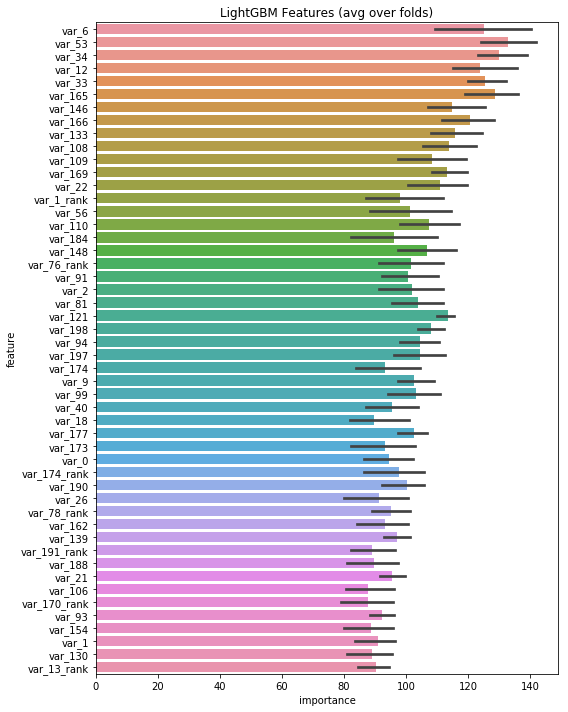

In [9]:
clfs = []
folds = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=random_seed)
oof_preds = np.zeros((len(train_df), 1))
test_preds = np.zeros((len(test_df), 1))

train_df = all_df.loc[all_df.target!=999]
test_df = all_df.loc[all_df.target==999]
del all_df
gc.collect()
X =  train_df[feats]
y = train_df['target']
X_test = test_df[feats]
test_ids = test_df.ID_code.values


parameters = {
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    #'scale_pos_weight': 400,
    #'device' : 'gpu' ,
    'boosting': 'gbdt',
    'num_leaves': 31, #31
    'feature_fraction': 0.5,
    'bagging_fraction': 0.7,
    'bagging_freq': 10,
    'learning_rate': 0.05, #0.05
    'verbose': 30
    #'min_data_in_leaf': 200
}

feature_importance_df = pd.DataFrame()
for fold_, (trn_, val_) in enumerate(folds.split(X, y)):
    print("Current Fold: {}".format(fold_+1))
    trn_x, trn_y = X.iloc[trn_, :], y[trn_]
    val_x, val_y = X.iloc[val_, :], y[val_]


    trn_lgb = lgb.Dataset(trn_x, trn_y)
    val_lgb = lgb.Dataset(val_x, val_y)
    clf = lgb.train(parameters,
                     train_set=trn_lgb,
                     #valid_sets=[valid_data_lgb,holdout_data_lgb],
                     valid_sets=[trn_lgb, val_lgb],
                     num_boost_round=3000,
                     early_stopping_rounds=50,
                     verbose_eval=False)
    


    val_pred = clf.predict(val_x)
    test_fold_pred = clf.predict(X_test)

    print("AUC = {}".format(roc_auc_score(val_y, val_pred)))
    oof_preds[val_, :] = val_pred.reshape((-1, 1))
    test_preds += test_fold_pred.reshape((-1, 1))
    
    print('getting feature importance')
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = feats
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    
test_preds /= n_folds
roc_score = roc_auc_score(y, oof_preds.ravel())
print("Overall AUC = {}".format(roc_score))


print("Saving submission file")
sample = pd.read_csv('../data/sample_submission.csv')
sample.target = test_preds.astype(float)
sample.ID_code = test_ids
sample.to_csv('../submissions/{}_{}.csv'.format(model_name,str(roc_score)), index=False)

display_importances(feature_importance_df)


In [10]:
%%javascript
var nb = IPython.notebook;
var kernel = IPython.notebook.kernel;
var command = "NOTEBOOK_FULL_PATH = '" + nb.base_url + nb.notebook_path + "'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [11]:


shutil.copyfile(os.path.basename(NOTEBOOK_FULL_PATH), 
                             '../models/{}_{}.ipynb'.format(model_name, str(roc_score)))


'../models/lgb_rank_pct_tran_and_test_5_folds_0.8927917474367043.ipynb'

In [26]:
display_importances(feature_importance_df)


/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)
